# Propósito

Este notebook tem como objetivo realizar uma análise exploratória de algumas colunas de interesse das medições dos sensores de qualidade do ar.

O principal objetivo será preencher alguns valores nulos utilizando a função interpolate()

Mas para não enviesar muitos dados preencheremos apenas os valores em que a quantidade de valores nulas no dia semana menor que 7


# Importações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from scipy.stats import shapiro, anderson, boxcox, kstest, norm
from scipy.special import boxcox1p
from scipy import stats

# Consumindo bases

In [2]:
url_sensor = '/content/drive/MyDrive/TCC/sensores-2011-2021/medicao-sensores.csv'

df_sensor = pd.read_csv(url_sensor, sep=',')

url_estacoes = '/content/drive/MyDrive/TCC/sensores-2011-2021/estacoes.csv'

df_estacoes = pd.read_csv(url_estacoes, sep=',')

In [3]:
df_sensor.columns

Index(['objectid', 'data', 'codnum', 'estação', 'chuva', 'pres', 'rs', 'temp',
       'ur', 'dir_vento', 'vel_vento', 'so2', 'no2', 'hcnm', 'hct', 'ch4',
       'co', 'no', 'nox', 'o3', 'pm10', 'pm2_5', 'lat', 'lon',
       'x_utm_sirgas2000', 'y_utm_sirgas2000'],
      dtype='object')

# Pré-processamento

## Selecionando e criando colunas

In [4]:
#@title Criando coluna nome estacao com base na coluna codnum
df_sensor['nome_estacao'] = df_sensor['codnum'].map(df_estacoes.set_index('codnum')['nome'])

In [5]:
#@title Selecionando as colunas mais relevantes
interest_columns = ['nome_estacao', 'data', 'chuva', 'temp', 'ur', 'co', 'no', 'no2', 'nox', 'so2', 'o3', 'pm10', 'pm2_5']

df_sensor_interest = df_sensor[interest_columns]

In [6]:
#@title Criando colunas de ano e mês para facilitar a análise temporal
df_sensor_interest['data'] = pd.to_datetime(df_sensor_interest['data'], format='%Y/%m/%d %H:%M:%S+00')
df_sensor_interest['data_formatada'] = pd.to_datetime(df_sensor_interest['data']).dt.strftime('%Y-%m-%d')
df_sensor_interest['ano'] = df_sensor_interest['data'].dt.year
df_sensor_interest['mes'] = df_sensor_interest['data'].dt.month

<ipython-input-6-f9a423e0dd73>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_interest['data'] = pd.to_datetime(df_sensor_interest['data'], format='%Y/%m/%d %H:%M:%S+00')
<ipython-input-6-f9a423e0dd73>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_interest['data_formatada'] = pd.to_datetime(df_sensor_interest['data']).dt.strftime('%Y-%m-%d')
<ipython-input-6-f9a423e0dd73>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [7]:
#@title Removendo ano de 2011 (Pela falta de alguns poluente) e anos da pandemia
df_sensor_interest_filtered = df_sensor_interest[(df_sensor_interest['ano'] > 2011) & (df_sensor_interest['ano'] < 2020)]

In [8]:
#@title Filtrando por Campo Grande
df_sensor_campo_grande = df_sensor_interest_filtered[df_sensor_interest_filtered['nome_estacao'] == 'ESTAÇÃO CAMPO GRANDE']

# Tratando colunas de interesse por Estação de monitoriamento


## Estação de Campo Grande
Colunas normalizadas: Chuva, Temperatura, Umidade relativa, CO, NO, NO2, NOx, SO2, O3, PM10

### Chuva Campo Grande

In [9]:
df_sensor_campo_grande['chuva'].describe()

,chuva
count,68954.000000
mean,0.133257
std,1.117465
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,49.800000


In [10]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_campo_grande[df_sensor_campo_grande['chuva'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 216


In [11]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_campo_grande['chuva_nulos_no_dia'] = (
    df_sensor_campo_grande['chuva'].isnull()
    .groupby(df_sensor_campo_grande['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-11-2bbe9c3354b9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_campo_grande['chuva_nulos_no_dia'] = (


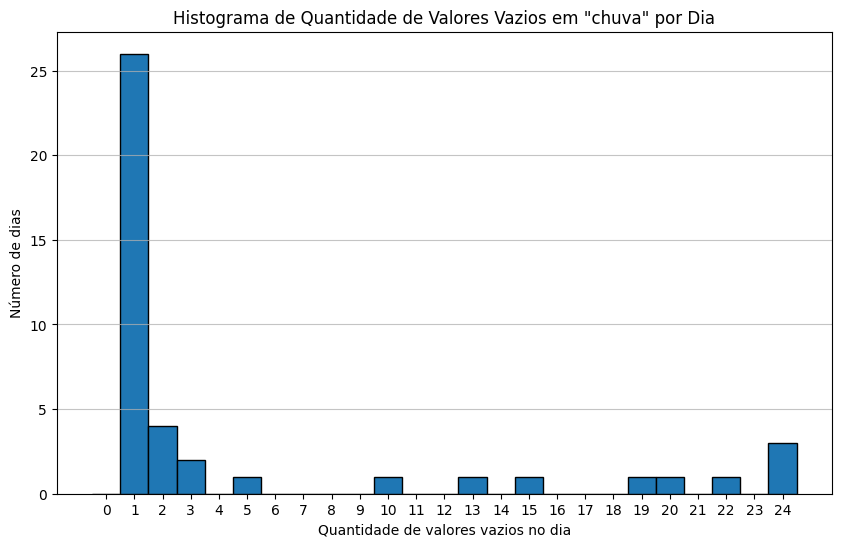

In [12]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_campo_grande[df_sensor_campo_grande['chuva_nulos_no_dia'] != 0].groupby('data_formatada')['chuva_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "chuva" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [13]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias)

mask = (df_sensor_campo_grande['chuva_nulos_no_dia'] <= 6)

num_nulls = df_sensor_campo_grande[mask]['chuva'].isnull().sum()
df_sensor_campo_grande.loc[mask, 'chuva'] = df_sensor_campo_grande[mask]['chuva'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'chuva'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

45 linhas foram preenchidas com interpolate na coluna 'chuva'.
Foram preenchido 21% de dados


In [14]:
df_sensor_campo_grande['chuva'].describe()

,chuva
count,68999.000000
mean,0.133274
std,1.117144
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,49.800000


### Temperatura Campo Grande

In [15]:
df_sensor_campo_grande['temp'].describe()

,temp
count,68681.000000
mean,27.611468
std,4.859175
min,14.370000
25%,24.070000
50%,26.930000
75%,30.520000
max,45.230000


In [16]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_campo_grande[df_sensor_campo_grande['temp'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 489


In [17]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_campo_grande['temp_nulos_no_dia'] = (
    df_sensor_campo_grande['temp'].isnull()
    .groupby(df_sensor_campo_grande['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-17-9119c5c8187e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_campo_grande['temp_nulos_no_dia'] = (


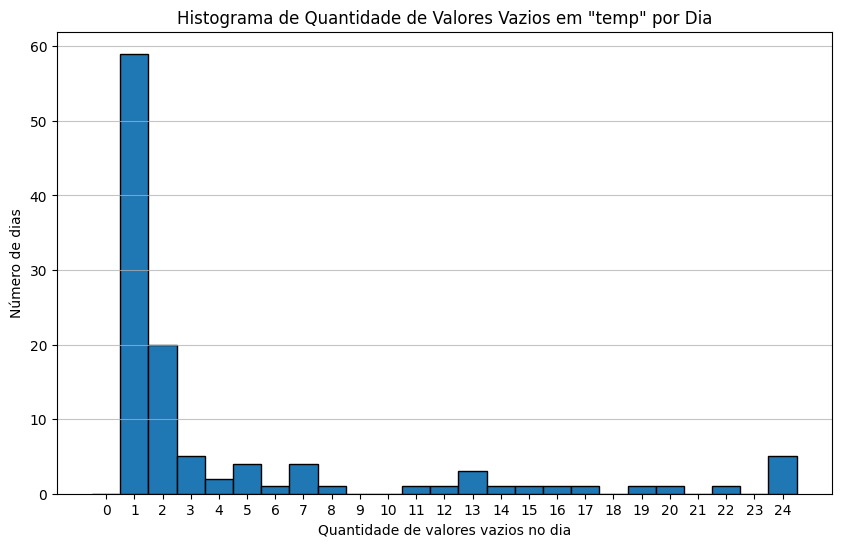

In [18]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_campo_grande[df_sensor_campo_grande['temp_nulos_no_dia'] != 0].groupby('data_formatada')['temp_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "temp" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [19]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_campo_grande['temp_nulos_no_dia'] <= 6)

num_nulls = df_sensor_campo_grande[mask]['temp'].isnull().sum()
df_sensor_campo_grande.loc[mask, 'temp'] = df_sensor_campo_grande[mask]['temp'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'temp'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

148 linhas foram preenchidas com interpolate na coluna 'temp'.
Foram preenchido 30% de dados


In [20]:
df_sensor_campo_grande['temp'].describe()

,temp
count,68829.000000
mean,27.614579
std,4.860017
min,14.370000
25%,24.070000
50%,26.930000
75%,30.520000
max,45.230000


### Umidade relativa Campo Grande

In [21]:
df_sensor_campo_grande['ur'].describe()

,ur
count,48835.000000
mean,72.729258
std,19.571804
min,0.760000
25%,57.980000
50%,75.020000
75%,89.800000
max,100.000000


In [22]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_campo_grande[df_sensor_campo_grande['ur'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 20335


In [23]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_campo_grande['ur_nulos_no_dia'] = (
    df_sensor_campo_grande['ur'].isnull()
    .groupby(df_sensor_campo_grande['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-23-f6735c965610>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_campo_grande['ur_nulos_no_dia'] = (


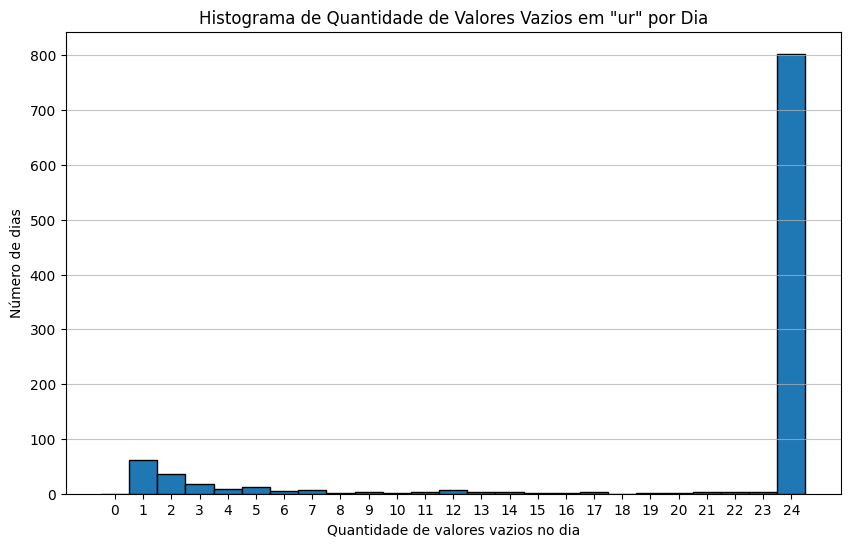

In [24]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_campo_grande[df_sensor_campo_grande['ur_nulos_no_dia'] != 0].groupby('data_formatada')['ur_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "ur" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [25]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_campo_grande['ur_nulos_no_dia'] <= 6)

num_nulls = df_sensor_campo_grande[mask]['ur'].isnull().sum()
df_sensor_campo_grande.loc[mask, 'ur'] = df_sensor_campo_grande[mask]['ur'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'ur'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

315 linhas foram preenchidas com interpolate na coluna 'ur'.
Foram preenchido 2% de dados


In [26]:
df_sensor_campo_grande['ur'].describe()

,ur
count,49150.000000
mean,72.789748
std,19.582369
min,0.760000
25%,58.030000
50%,75.080000
75%,89.930000
max,100.000000


### Monóxido de carbono Campo Grande

In [27]:
df_sensor_campo_grande['co'].describe()

,co
count,64717.000000
mean,0.380616
std,0.245913
min,0.000000
25%,0.220000
50%,0.330000
75%,0.480000
max,2.850000


In [28]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_campo_grande[df_sensor_campo_grande['co'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 4453


In [29]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_campo_grande['co_nulos_no_dia'] = (
    df_sensor_campo_grande['co'].isnull()
    .groupby(df_sensor_campo_grande['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-29-dedbf5df853b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_campo_grande['co_nulos_no_dia'] = (


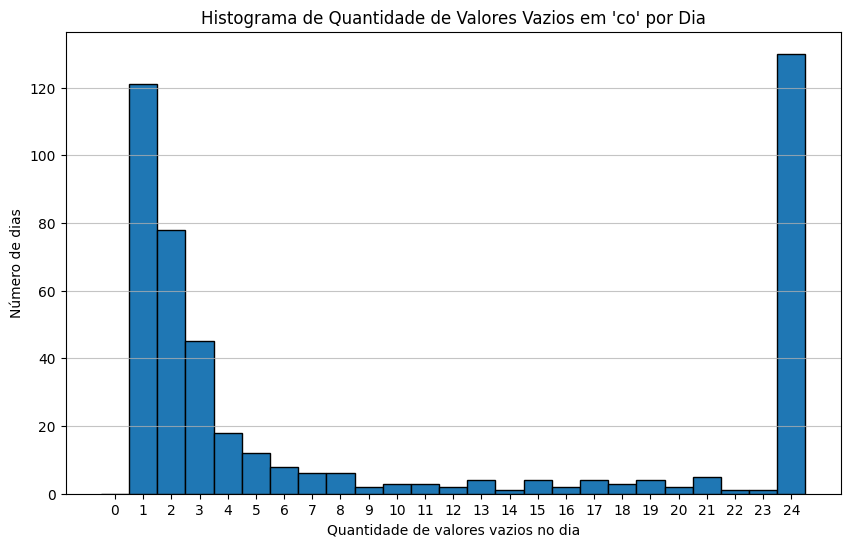

In [30]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_campo_grande[df_sensor_campo_grande['co_nulos_no_dia'] != 0].groupby('data_formatada')['co_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'co' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [31]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_campo_grande['co_nulos_no_dia'] <= 6)

num_nulls = df_sensor_campo_grande[mask]['co'].isnull().sum()
df_sensor_campo_grande.loc[mask, 'co'] = df_sensor_campo_grande[mask]['co'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'co'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

592 linhas foram preenchidas com interpolate na coluna 'co'.
Foram preenchido 13% de dados


In [32]:
df_sensor_campo_grande['co'].describe()

,co
count,65309.000000
mean,0.380806
std,0.245746
min,0.000000
25%,0.220000
50%,0.330000
75%,0.480000
max,2.850000


### Monóxido de Nitrogênio Campo Grande

In [33]:
df_sensor_campo_grande['no'].describe()

,no
count,64592.000000
mean,23.434584
std,33.447360
min,0.000000
25%,4.150000
50%,11.050000
75%,28.140000
max,597.690000


In [34]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_campo_grande[df_sensor_campo_grande['no'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 4578


In [35]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_campo_grande['no_nulos_no_dia'] = (
    df_sensor_campo_grande['no'].isnull()
    .groupby(df_sensor_campo_grande['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-35-07be3903a9ac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_campo_grande['no_nulos_no_dia'] = (


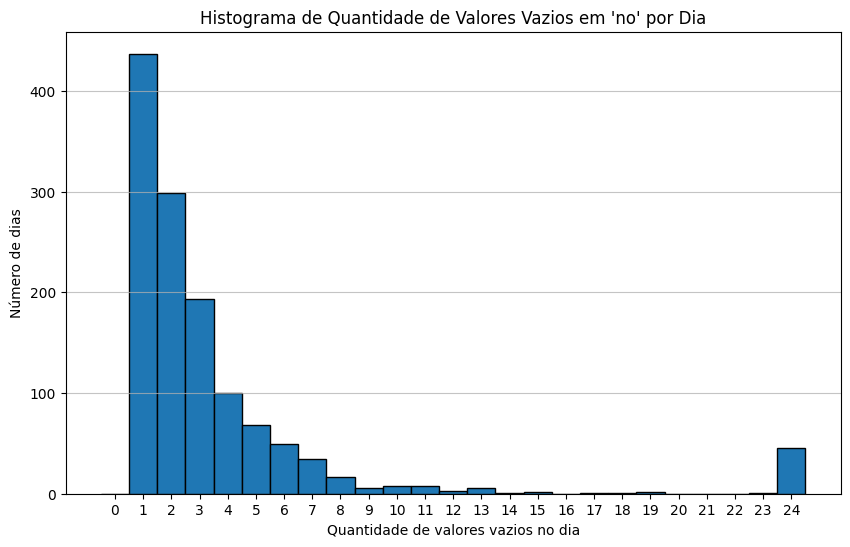

In [36]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_campo_grande[df_sensor_campo_grande['no_nulos_no_dia'] != 0].groupby('data_formatada')['no_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'no' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [37]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_campo_grande['no_nulos_no_dia'] <= 6)

num_nulls = df_sensor_campo_grande[mask]['no'].isnull().sum()
df_sensor_campo_grande.loc[mask, 'no'] = df_sensor_campo_grande[mask]['no'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'no'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

2648 linhas foram preenchidas com interpolate na coluna 'no'.
Foram preenchido 58% de dados


In [38]:
df_sensor_campo_grande['no'].describe()

,no
count,67240.000000
mean,22.972031
std,33.116462
min,0.000000
25%,3.950000
50%,10.690000
75%,27.490000
max,597.690000


### Dióxido de Nitrogênio Campo Grande

In [39]:
df_sensor_campo_grande['no2'].describe()

,no2
count,64620.000000
mean,33.581584
std,16.670087
min,1.160000
25%,21.720000
50%,31.045000
75%,42.220000
max,161.220000


In [40]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_campo_grande[df_sensor_campo_grande['no2'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 4550


In [41]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_campo_grande['no2_nulos_no_dia'] = (
    df_sensor_campo_grande['no2'].isnull()
    .groupby(df_sensor_campo_grande['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-41-8453872114ba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_campo_grande['no2_nulos_no_dia'] = (


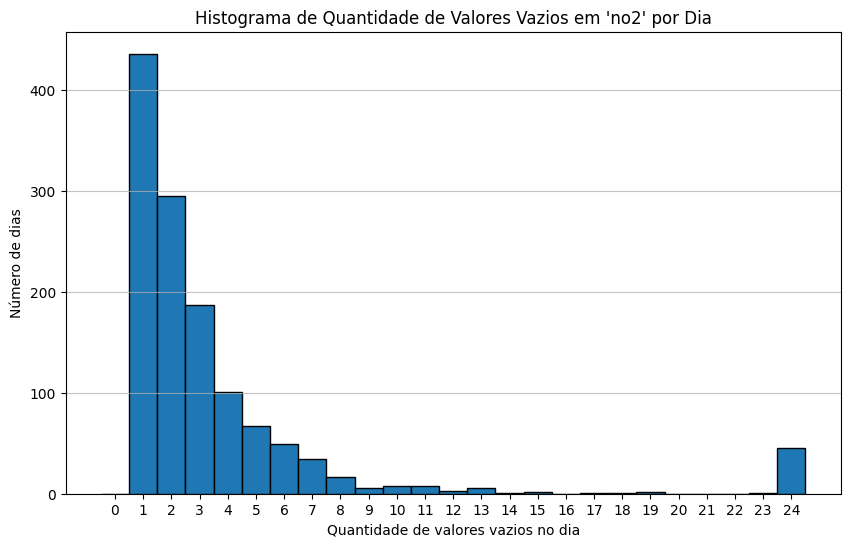

In [42]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_campo_grande[df_sensor_campo_grande['no2_nulos_no_dia'] != 0].groupby('data_formatada')['no2_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'no2' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [43]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_campo_grande['no2_nulos_no_dia'] <= 6)

num_nulls = df_sensor_campo_grande[mask]['no2'].isnull().sum()
df_sensor_campo_grande.loc[mask, 'no2'] = df_sensor_campo_grande[mask]['no2'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'no2'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

2620 linhas foram preenchidas com interpolate na coluna 'no2'.
Foram preenchido 58% de dados


In [44]:
df_sensor_campo_grande['no2'].describe()

,no2
count,67240.000000
mean,33.259396
std,16.620727
min,1.160000
25%,21.410000
50%,30.690000
75%,41.872500
max,161.220000


### Óxido de Nitrogênio Campo Grande

In [45]:
df_sensor_campo_grande['nox'].describe()

,nox
count,64599.000000
mean,57.019517
std,44.033298
min,1.960000
25%,28.085000
50%,44.520000
75%,71.495000
max,685.740000


In [46]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_campo_grande[df_sensor_campo_grande['nox'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 4571


In [47]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_campo_grande['nox_nulos_no_dia'] = (
    df_sensor_campo_grande['nox'].isnull()
    .groupby(df_sensor_campo_grande['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-47-dbcdbfa20a88>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_campo_grande['nox_nulos_no_dia'] = (


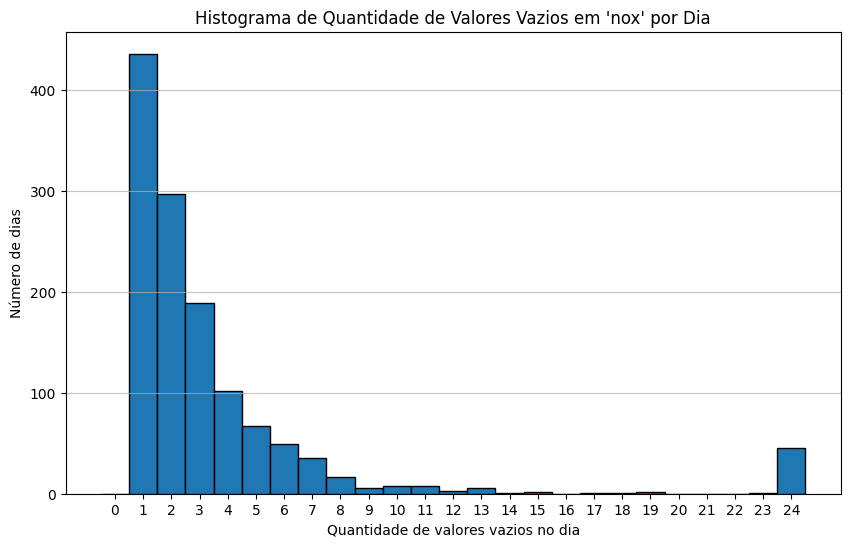

In [48]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_campo_grande[df_sensor_campo_grande['nox_nulos_no_dia'] != 0].groupby('data_formatada')['nox_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'nox' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [49]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_campo_grande['nox_nulos_no_dia'] <= 6)

num_nulls = df_sensor_campo_grande[mask]['nox'].isnull().sum()
df_sensor_campo_grande.loc[mask, 'nox'] = df_sensor_campo_grande[mask]['nox'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'nox'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

2634 linhas foram preenchidas com interpolate na coluna 'nox'.
Foram preenchido 58% de dados


In [50]:
df_sensor_campo_grande['nox'].describe()

,nox
count,67233.000000
mean,56.236810
std,43.735974
min,1.960000
25%,27.460000
50%,43.770000
75%,70.510000
max,685.740000


### Dióxido de Enxofre Campo Grande

In [51]:
df_sensor_campo_grande['so2'].describe()

,so2
count,62034.000000
mean,2.837746
std,4.113086
min,0.000000
25%,0.320000
50%,1.830000
75%,4.080000
max,199.230000


In [52]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_campo_grande[df_sensor_campo_grande['so2'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 7136


In [53]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_campo_grande['so2_nulos_no_dia'] = (
    df_sensor_campo_grande['so2'].isnull()
    .groupby(df_sensor_campo_grande['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-53-060f894af480>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_campo_grande['so2_nulos_no_dia'] = (


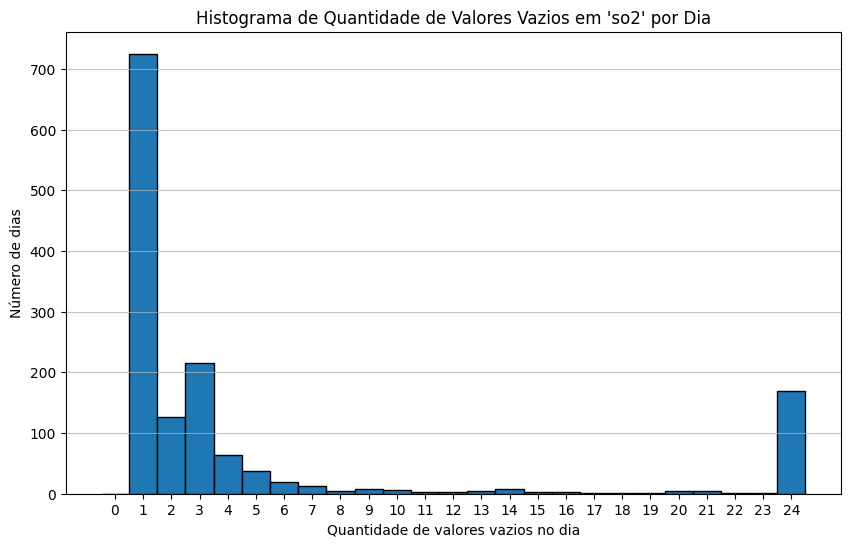

In [54]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_campo_grande[df_sensor_campo_grande['so2_nulos_no_dia'] != 0].groupby('data_formatada')['so2_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'so2' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [55]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_campo_grande['so2_nulos_no_dia'] <= 6)

num_nulls = df_sensor_campo_grande[mask]['so2'].isnull().sum()
df_sensor_campo_grande.loc[mask, 'so2'] = df_sensor_campo_grande[mask]['so2'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'so2'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

2181 linhas foram preenchidas com interpolate na coluna 'so2'.
Foram preenchido 31% de dados


In [56]:
df_sensor_campo_grande['so2'].describe()

,so2
count,64215.000000
mean,2.835139
std,4.082663
min,0.000000
25%,0.330000
50%,1.840000
75%,4.070000
max,199.230000


### Ozônio Campo Grande

In [57]:
df_sensor_campo_grande['o3'].describe()

,o3
count,65791.000000
mean,32.934858
std,29.268122
min,0.000000
25%,8.830000
50%,26.700000
75%,49.310000
max,307.760000


In [58]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_campo_grande[df_sensor_campo_grande['o3'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 3379


In [59]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_campo_grande['o3_nulos_no_dia'] = (
    df_sensor_campo_grande['o3'].isnull()
    .groupby(df_sensor_campo_grande['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-59-6513e36c9ca4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_campo_grande['o3_nulos_no_dia'] = (


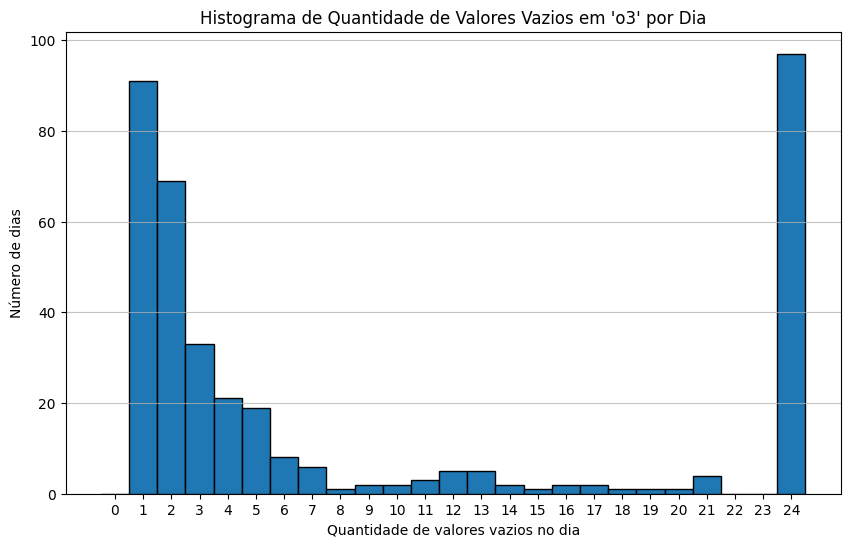

In [60]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_campo_grande[df_sensor_campo_grande['o3_nulos_no_dia'] != 0].groupby('data_formatada')['o3_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'o3' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [61]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_campo_grande['o3_nulos_no_dia'] <= 6)

num_nulls = df_sensor_campo_grande[mask]['o3'].isnull().sum()
df_sensor_campo_grande.loc[mask, 'o3'] = df_sensor_campo_grande[mask]['o3'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'o3'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

555 linhas foram preenchidas com interpolate na coluna 'o3'.
Foram preenchido 16% de dados


In [62]:
df_sensor_campo_grande['o3'].describe()

,o3
count,66346.000000
mean,33.010361
std,29.281151
min,0.000000
25%,8.912500
50%,26.800000
75%,49.380000
max,307.760000


### PM10 Campo Grande

In [63]:
df_sensor_campo_grande['pm10'].describe()

,pm10
count,65052.000000
mean,33.805370
std,20.599051
min,0.000000
25%,21.000000
50%,29.000000
75%,41.000000
max,256.000000


In [64]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_campo_grande[df_sensor_campo_grande['pm10'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 4118


In [65]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_campo_grande['pm10_nulos_no_dia'] = (
    df_sensor_campo_grande['pm10'].isnull()
    .groupby(df_sensor_campo_grande['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-65-3eaa12e57c7e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_campo_grande['pm10_nulos_no_dia'] = (


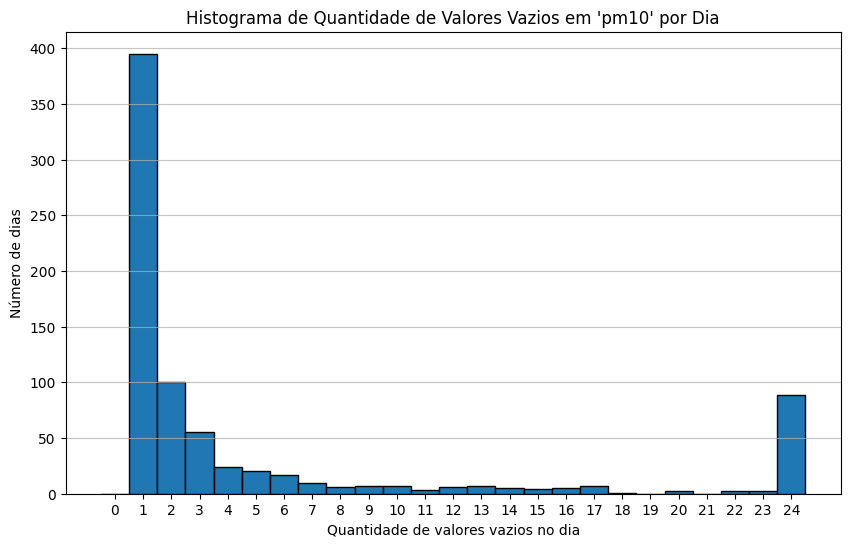

In [66]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_campo_grande[df_sensor_campo_grande['pm10_nulos_no_dia'] != 0].groupby('data_formatada')['pm10_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'pm10' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [67]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_campo_grande['pm10_nulos_no_dia'] <= 6)

num_nulls = df_sensor_campo_grande[mask]['pm10'].isnull().sum()
df_sensor_campo_grande.loc[mask, 'pm10'] = df_sensor_campo_grande[mask]['pm10'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'pm10'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

1058 linhas foram preenchidas com interpolate na coluna 'pm10'.
Foram preenchido 26% de dados


In [68]:
df_sensor_campo_grande['pm10'].describe()

,pm10
count,66110.000000
mean,33.849425
std,20.603207
min,0.000000
25%,21.000000
50%,29.000000
75%,41.300000
max,256.000000


# Gerando CSV de saída com a estação de Campo Grande preenchida


In [69]:
df_sensor_campo_grande.to_csv('df_sensor_campo_grande_preenchido.csv', index=False)